In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip

import copy

import import_ipynb
from _My_Functions import null_cols, rmse

importing Jupyter notebook from _My_Functions.ipynb


In [2]:
acc_2_train = pd.read_csv("acc_2_train_final.csv.gz",
                          compression='gzip',
                          header=0,
                          sep=',',
                          quotechar='"')

acc_2_comparison = pd.read_csv("acc_2_train_comparison.csv.gz",
                               compression='gzip',
                               header=0,
                               sep=',',
                               quotechar='"')

target_2_train = pd.read_csv("target_2_train_final.csv.gz",
                             compression='gzip',
                             header=0,
                             sep=',',
                             quotechar='"')

In [3]:
# separate and drop 'total_pymnt'

ttlpy_2_dwnsmpl = copy.deepcopy(acc_2_comparison[['total_pymnt']])

acc_2_train

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,dti,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,mths_since_rcnt_il,total_bal_il,il_util,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_mths_since_last_major_derog,duration_of_credit_months,fico_score,sec_app_fico_score,sec_app_duration_of_credit_months,grouped_grade_NO_EG,grouped_subgrade_12_345,grouped_subgrade_123_45,grouped_subgrade,annual_inc_reduced,annual_inc_joint_reduced,weighted_loan_amnt,weighted_funded_amnt,weighted_installment,ratio_inc_loan,ratio_inc_weightedloan,ratio_redinc_loan,ratio_redinc_weightedloan,ratio_inc_funded,ratio_inc_weightedfunded,ratio_redinc_funded,ratio_redinc_weightedfunded,ratio_install_inc,ratio_weightedinstall_inc,ratio_install_redinc,ratio_weightedinstall_redinc,ratio_incjoint_loan,ratio_incjoint_weightedloan,ratio_redincjoint_loan,ratio_redincjoint_weightedloan,ratio_incjoint_funded,ratio_incjoint_weightedfunded,ratio_redincjoint_funded,ratio_redincjoint_weightedfunded,ratio_incjoint_installment,ratio_incjoint_weightedinstallment,ratio_redincjoint_installment,ratio_redincjoint_weightedinstallment,loan_minus_funded,ratio_loan_funded,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,issue_d_Apr-2009,issue_d_Apr-2010,issue_d_Apr-2011,issue_d_Apr-2012,issue_d_Apr-2013,issue_d_Apr-2014,issue_d_Apr-2015,issue_d_Apr-2016,issue_d_Apr-2017,issue_d_Apr-2018,issue_d_Aug-2007,issue_d_Aug-2008,issue_d_Aug-2009,issue_d_Aug-2010,issue_d_Aug-2011,issue_d_Aug-2012,issue_d_Aug-2013,issue_d_Aug-2014,issue_d_Aug-2015,issue_d_Aug-2016,issue_d_Aug-2017,issue_d_Aug-2018,issue_d_Dec-2007,issue_d_Dec-2008,issue_d_Dec-2009,issue_d_Dec-2010,issue_d_Dec-2011,issue_d_Dec-2012,issue_d_Dec-2013,issue_d_Dec-2014,issue_d_Dec-2015,issue_d_Dec-2016,issue_d_Dec-2017,issue_d_Dec-2018,issue_d_Feb-2008,issue_d_Feb-2009,issue_d_Feb-2010,issue_d_Feb-2011,issue_d_Feb-2012,issue_d_Feb-2013,issue_d_Feb-2014,issue_d_Feb-2015,issue_d_Feb-2016,issue_d_Feb-2017,issue_d_Feb-2018,issue_d_Jan-2008,issue_d_Jan-2009,issue_d_Jan-2010,issue_d_Jan-2011,issue_d_Jan-2012,issue_d_Jan-2013,issue_d_Jan-2014,issue_d_Jan-2015,issue_d_Jan-2016,issue_d_Jan-2017,issue_d_Jan-2018,issue_d_Jul-2007,issue_d_Jul-2008,issue_d_Jul-2009,issue_d_Jul-2010,issue_d_Jul-2011,issue_d_Jul-2012,issue_d_Jul-2013,issue_d_Jul-2014,issue_d_Jul-2015,issue_d_Jul-2016,issue_d_Jul-2017,issue_d_Jul-2018,issue_d_Jun-2007,issue_d_Jun-2008,issue_d_Jun-2009,issue_d_Jun-2010,issue_d_Jun-2011,issue_d_Jun-2012,issue_d_Jun-2013,issue_d_Jun-2014,issue_d_Jun-2015,issue_d_Jun-2016,issue_d_Jun-2017,issue_d_Jun-2018,issue_d_Mar-2008,issue_d_Mar-2009,issue_d_Mar-2010,issue_d_Mar-2011,issue_d_Mar-2012,issue_d_Mar-2013,issue_d_Mar-2014,issue_d_Mar-2015,issue

In [4]:
state=0

# downsampled:
xtrain_ds, xtest_ds, ytrain_ds, ytest_ds = ms.train_test_split(acc_2_train,
                                                               target_2_train,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_ds = ytrain_ds.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Downsampled Data

In [5]:
xgb_clsfr_ds = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']


gparam_xgb_ds = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
                 'random_state': randomstate}


gs_xgb_ds = ms.GridSearchCV(xgb_clsfr_ds, gparam_xgb_ds, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_ds.fit(xtrain_ds, ytrain_ds)

# setting up dataframe for results
train_scores.append(gs_xgb_ds.best_estimator_.score(xtrain_ds, ytrain_ds))
test_scores.append(gs_xgb_ds.best_estimator_.score(xtest_ds, ytest_ds))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_ds, ytrain_ds, xtrain_ds))
test_rmse.append(rmse(gs_xgb_ds, ytest_ds, xtest_ds))

# add the best parameters to the df
best_par_list.append(gs_xgb_ds.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_ds, gs_xgb_ds.predict(xtrain_ds)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_ds, gs_xgb_ds.predict(xtest_ds)))

res_df

Wall time: 19.4 s


confusion matrix for train set
[[75059 32651]
 [29942 77836]]


confusion matrix for test set
[[17684  9286]
 [ 8663 18239]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.709529,0.666821,0.538954,0.577216,-0.038263,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [6]:
sorted_importance = sorted(zip(xtrain_ds.columns,
                               gs_xgb_ds.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance

[('grade', 0.2774751),
 ('grouped_subgrade', 0.12142022),
 ('grouped_subgrade_12_345', 0.09130543),
 ('grouped_subgrade_123_45', 0.031754304),
 ('ratio_inc_weightedfunded', 0.02015814),
 ('term', 0.012128311),
 ('ratio_inc_weightedloan', 0.0064206384),
 ('ratio_inc_funded', 0.0059382366),
 ('issue_d_Oct-2018', 0.005493581),
 ('issue_d_Nov-2018', 0.0054488736),
 ('issue_d_Aug-2018', 0.0053430093),
 ('home_ownership', 0.0051658186),
 ('ratio_incjoint_weightedfunded', 0.0051613427),
 ('purpose_small_business', 0.004953633),
 ('issue_d_Dec-2018', 0.00483903),
 ('num_actv_rev_tl', 0.0048337835),
 ('issue_d_Sep-2018', 0.004783533),
 ('all_util', 0.00473377),
 ('verification_status', 0.004599687),
 ('issue_d_May-2016', 0.004596215),
 ('mort_acc', 0.0042151944),
 ('issue_d_Jan-2014', 0.0039096456),
 ('issue_d_Jan-2016', 0.0036127013),
 ('sub_grade_D2', 0.003574333),
 ('emp_length', 0.0034367186),
 ('avg_cur_bal', 0.0034316205),
 ('issue_d_Jul-2018', 0.0033920384),
 ('issue_d_Aug-2013', 0.00331

In [7]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.61


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.61')

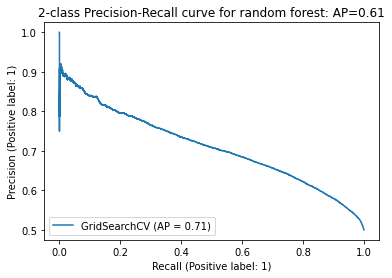

In [8]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_ds, xtest_ds, ytest_ds)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [9]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
recall_score = metrics.recall_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
precision_score = metrics.precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.67
recall score: 0.68
precision score: 0.66


In [10]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6668354207379056

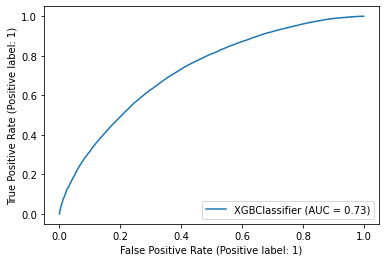

In [11]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_ds.best_estimator_, xtest_ds, ytest_ds) 

In [12]:
filtered_sorted_importance = [x for x in sorted_importance if x[1]>0.003]
filtered_sorted_importance

[('grade', 0.2774751),
 ('grouped_subgrade', 0.12142022),
 ('grouped_subgrade_12_345', 0.09130543),
 ('grouped_subgrade_123_45', 0.031754304),
 ('ratio_inc_weightedfunded', 0.02015814),
 ('term', 0.012128311),
 ('ratio_inc_weightedloan', 0.0064206384),
 ('ratio_inc_funded', 0.0059382366),
 ('issue_d_Oct-2018', 0.005493581),
 ('issue_d_Nov-2018', 0.0054488736),
 ('issue_d_Aug-2018', 0.0053430093),
 ('home_ownership', 0.0051658186),
 ('ratio_incjoint_weightedfunded', 0.0051613427),
 ('purpose_small_business', 0.004953633),
 ('issue_d_Dec-2018', 0.00483903),
 ('num_actv_rev_tl', 0.0048337835),
 ('issue_d_Sep-2018', 0.004783533),
 ('all_util', 0.00473377),
 ('verification_status', 0.004599687),
 ('issue_d_May-2016', 0.004596215),
 ('mort_acc', 0.0042151944),
 ('issue_d_Jan-2014', 0.0039096456),
 ('issue_d_Jan-2016', 0.0036127013),
 ('sub_grade_D2', 0.003574333),
 ('emp_length', 0.0034367186),
 ('avg_cur_bal', 0.0034316205),
 ('issue_d_Jul-2018', 0.0033920384),
 ('issue_d_Aug-2013', 0.00331

In [13]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance:
    filter_important.append(tup[0])

filter_important

['grade',
 'grouped_subgrade',
 'grouped_subgrade_12_345',
 'grouped_subgrade_123_45',
 'ratio_inc_weightedfunded',
 'term',
 'ratio_inc_weightedloan',
 'ratio_inc_funded',
 'issue_d_Oct-2018',
 'issue_d_Nov-2018',
 'issue_d_Aug-2018',
 'home_ownership',
 'ratio_incjoint_weightedfunded',
 'purpose_small_business',
 'issue_d_Dec-2018',
 'num_actv_rev_tl',
 'issue_d_Sep-2018',
 'all_util',
 'verification_status',
 'issue_d_May-2016',
 'mort_acc',
 'issue_d_Jan-2014',
 'issue_d_Jan-2016',
 'sub_grade_D2',
 'emp_length',
 'avg_cur_bal',
 'issue_d_Jul-2018',
 'issue_d_Aug-2013',
 'dti',
 'issue_d_Oct-2013',
 'sec_app_inq_last_6mths']

In [14]:
len(filter_important)

31

In [15]:
acc_2_train2 = copy.deepcopy(acc_2_train[filter_important])

In [16]:
state=0

# downsampled:
xtrain, xtest, ytrain, ytest = ms.train_test_split(acc_2_train2,
                                                   target_2_train,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()


# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [17]:
xgb_clsfr = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']


gparam_xgb = {'objective': objective_,
              'eval_metric': evalmetric,
              'use_label_encoder': uselabelencoder,
              'tree_method': treemethod,
              'predictor': predictor_,
              'n_jobs': njobs,
              'booster': booster_,
              'random_state': randomstate}


gs_xgb = ms.GridSearchCV(xgb_clsfr, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain, gs_xgb.predict(xtrain)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest, gs_xgb.predict(xtest)))

res_df

Wall time: 7.65 s


confusion matrix for train set
[[72061 35649]
 [32462 75316]]


confusion matrix for test set
[[17370  9600]
 [ 8791 18111]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.683922,0.658617,0.562208,0.58428,-0.022072,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [18]:
sorted_importance = sorted(zip(xtrain.columns,
                               gs_xgb.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance

[('grade', 0.3919132),
 ('grouped_subgrade', 0.10933612),
 ('grouped_subgrade_12_345', 0.06632929),
 ('term', 0.056270447),
 ('issue_d_Nov-2018', 0.02289651),
 ('issue_d_Oct-2018', 0.022759158),
 ('ratio_inc_weightedloan', 0.021280326),
 ('issue_d_Dec-2018', 0.021251148),
 ('issue_d_Sep-2018', 0.01961925),
 ('issue_d_Aug-2018', 0.018636296),
 ('home_ownership', 0.018486708),
 ('purpose_small_business', 0.017682904),
 ('issue_d_Oct-2013', 0.014491509),
 ('issue_d_May-2016', 0.014183682),
 ('ratio_inc_weightedfunded', 0.014169761),
 ('issue_d_Aug-2013', 0.013788134),
 ('grouped_subgrade_123_45', 0.0135499835),
 ('all_util', 0.013528214),
 ('issue_d_Jul-2018', 0.012685905),
 ('mort_acc', 0.01243556),
 ('verification_status', 0.011553654),
 ('sec_app_inq_last_6mths', 0.01098559),
 ('emp_length', 0.010950686),
 ('avg_cur_bal', 0.010709734),
 ('issue_d_Jan-2014', 0.010615564),
 ('num_actv_rev_tl', 0.010472524),
 ('issue_d_Jan-2016', 0.010059824),
 ('dti', 0.0090565225),
 ('ratio_inc_funded',

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest, gs_xgb.predict(xtest))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.60')

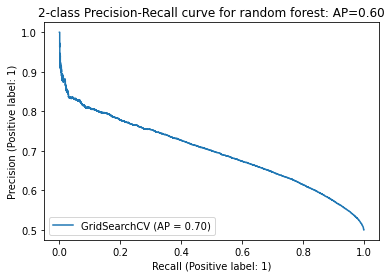

In [20]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb, xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [21]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest, gs_xgb.predict(xtest))
recall_score = metrics.recall_score(ytest, gs_xgb.predict(xtest))
precision_score = metrics.precision_score(ytest, gs_xgb.predict(xtest))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.66
recall score: 0.67
precision score: 0.65


In [22]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest, gs_xgb.predict(xtest))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6586351325525541

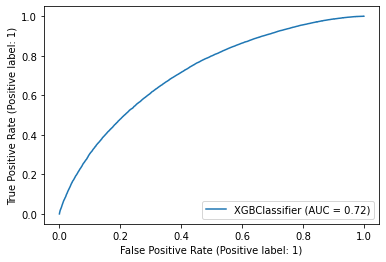

In [23]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb.best_estimator_, xtest, ytest) 

In [24]:
filtered_sorted_importance = [x for x in sorted_importance if x[1]>0.003]
filtered_sorted_importance

[('grade', 0.3919132),
 ('grouped_subgrade', 0.10933612),
 ('grouped_subgrade_12_345', 0.06632929),
 ('term', 0.056270447),
 ('issue_d_Nov-2018', 0.02289651),
 ('issue_d_Oct-2018', 0.022759158),
 ('ratio_inc_weightedloan', 0.021280326),
 ('issue_d_Dec-2018', 0.021251148),
 ('issue_d_Sep-2018', 0.01961925),
 ('issue_d_Aug-2018', 0.018636296),
 ('home_ownership', 0.018486708),
 ('purpose_small_business', 0.017682904),
 ('issue_d_Oct-2013', 0.014491509),
 ('issue_d_May-2016', 0.014183682),
 ('ratio_inc_weightedfunded', 0.014169761),
 ('issue_d_Aug-2013', 0.013788134),
 ('grouped_subgrade_123_45', 0.0135499835),
 ('all_util', 0.013528214),
 ('issue_d_Jul-2018', 0.012685905),
 ('mort_acc', 0.01243556),
 ('verification_status', 0.011553654),
 ('sec_app_inq_last_6mths', 0.01098559),
 ('emp_length', 0.010950686),
 ('avg_cur_bal', 0.010709734),
 ('issue_d_Jan-2014', 0.010615564),
 ('num_actv_rev_tl', 0.010472524),
 ('issue_d_Jan-2016', 0.010059824),
 ('dti', 0.0090565225),
 ('ratio_inc_funded',

In [25]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance:
    filter_important.append(tup[0])

filter_important

['grade',
 'grouped_subgrade',
 'grouped_subgrade_12_345',
 'term',
 'issue_d_Nov-2018',
 'issue_d_Oct-2018',
 'ratio_inc_weightedloan',
 'issue_d_Dec-2018',
 'issue_d_Sep-2018',
 'issue_d_Aug-2018',
 'home_ownership',
 'purpose_small_business',
 'issue_d_Oct-2013',
 'issue_d_May-2016',
 'ratio_inc_weightedfunded',
 'issue_d_Aug-2013',
 'grouped_subgrade_123_45',
 'all_util',
 'issue_d_Jul-2018',
 'mort_acc',
 'verification_status',
 'sec_app_inq_last_6mths',
 'emp_length',
 'avg_cur_bal',
 'issue_d_Jan-2014',
 'num_actv_rev_tl',
 'issue_d_Jan-2016',
 'dti',
 'ratio_inc_funded',
 'ratio_incjoint_weightedfunded',
 'sub_grade_D2']